# Bank Marketing Campaign 

**The aim of this notebook is to build a machine learning model to help ABC Bank identify the right customers to target
for their marketing campaign by classification of people buying term deposit or not.**


# Exploratory Data Analysis

In this notebook, we will go through the following steps. 

1. Data Preparation
   
   - Importing libraries
   - Data Ingestion
   - Data Overview/(Data Intake)
   - Categorical & Numerical variables
   

2. **Model Preparation**


3. **Model Building**
            
    
4. Communication

===================================================================================================

# Data Preparation

 ## Import Libraries 

In [1]:
# !pip install feature_engine

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import xgboost
from sklearn.metrics import accuracy_score #metrics

# from feature-engine
from feature_engine.imputation import (
    AddMissingIndicator,
    MeanMedianImputer,
    CategoricalImputer,
)

from feature_engine.transformation import (
    LogTransformer,
    YeoJohnsonTransformer,
)

from sklearn.preprocessing import MinMaxScaler,LabelEncoder

from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Data Ingestion

### Testutility file

In [4]:
%%writefile testutility.py
import logging
import os
import subprocess
import yaml 
import pandas as pd
import datetime
import gc
import re

#################
# File Reading #
#################

def read_config_file(filepath):
  with open(filepath, "r") as stream:
    try:
      return yaml.safe_load(stream)
    except yaml.YAMLError as exc:
      logging.error(exc)

Overwriting testutility.py


### Yaml file

In [5]:
%%writefile file.yaml
file_type: csv
dataset_name: testfile
file_name: bank-additional-full
table_name: edsurv
inbound_delimeter: ";"
outbound_delimeter: "|"

Overwriting file.yaml


In [6]:
# Read Config file
import testutility as util
config_data = util.read_config_file("file.yaml")

In [7]:
config_data["file_name"]

'bank-additional-full'

In [8]:
# read the files using config file
file_type = config_data["file_type"]
source_file = "./" + config_data["file_name"] + f".{file_type}"

# print("", source_file)
df = pd.read_csv(source_file, config_data["inbound_delimeter"])

## Data Overview

In [9]:
df.shape

(41188, 21)

In [10]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [12]:
import os
def summary(df, source_file):
    rows = len(df)
    columns = len(df.columns)
    print(f"Number of Rows: {rows}")
    print(f"Number of Columns: {columns}")
    file_size = os.path.getsize(source_file)
    print(f"Size: {file_size} bytes")

In [13]:
summary(df, source_file)

Number of Rows: 41188
Number of Columns: 21
Size: 5834924 bytes


In [14]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [15]:
df.duplicated().sum()

12

In [16]:
# Remove Duplicates
df = df.drop_duplicates()

In [17]:
df.duplicated().sum()

0

In [18]:
df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

Data types are correctly assigned

In [19]:
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

Now, as per above result,  we can see there is no any duplicate value nor null value.

## Categorical & Numerical variables

### Variable Types

#### Target Variable

In [20]:
target_var = ['y']
target = df[target_var]
target_var

['y']

In [21]:
df["y"].unique()

array(['no', 'yes'], dtype=object)

#### Categorical Variables

In [22]:
categorical_var = [var for var in df.columns 
                   if df[var].dtype=="O" and 
                   var not in target_var and 
                   var not in ["month", "day_of_week", "default"]]
categorical_var

['job', 'marital', 'education', 'housing', 'loan', 'contact', 'poutcome']

#### Numeric Variables

In [23]:
numerical_var = [var for var in df.columns if var not in categorical_var + target_var and var not in ["month", "day_of_week"]]
numerical_var

['age',
 'default',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

#### Temporal Variables 

In [24]:
temporal_var = [var for var in df.columns if var =="month" or var=="day_of_week"]
temporal_var

['month', 'day_of_week']

In [25]:
# let's explore the values of these temporal variables

for var in temporal_var:
    print(var, df[var].unique())
    print()

month ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']

day_of_week ['mon' 'tue' 'wed' 'thu' 'fri']



#### Discreete Variable 

In [26]:
discrete_var = [var for var in numerical_var if len(df[var].unique()) < 32 and var not in temporal_var]
discrete_var

['default',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'nr.employed']

In [27]:
# let's explore the values of these discrete variables

for var in discrete_var:
    print(var, df[var].unique())
    print()

default ['no' 'unknown' 'yes']

pdays [999   6   4   3   5   1   0  10   7   8   9  11   2  12  13  14  15  16
  21  17  18  22  25  26  19  27  20]

previous [0 1 2 3 4 5 6 7]

emp.var.rate [ 1.1  1.4 -0.1 -0.2 -1.8 -2.9 -3.4 -3.  -1.7 -1.1]

cons.price.idx [93.994 94.465 93.918 93.444 93.798 93.2   92.756 92.843 93.075 92.893
 92.963 92.469 92.201 92.379 92.431 92.649 92.713 93.369 93.749 93.876
 94.055 94.215 94.027 94.199 94.601 94.767]

cons.conf.idx [-36.4 -41.8 -42.7 -36.1 -40.4 -42.  -45.9 -50.  -47.1 -46.2 -40.8 -33.6
 -31.4 -29.8 -26.9 -30.1 -33.  -34.8 -34.6 -40.  -39.8 -40.3 -38.3 -37.5
 -49.5 -50.8]

nr.employed [5191.  5228.1 5195.8 5176.3 5099.1 5076.2 5017.5 5023.5 5008.7 4991.6
 4963.6]



##### Continuous variables 

In [28]:
# make list of continuous variables
continuous_var = [
    var for var in numerical_var if var not in discrete_var+temporal_var]
continuous_var

['age', 'duration', 'campaign', 'euribor3m']

In [29]:
# let's explore the values of these temporal variables

for var in continuous_var:
    print(var, df[var].unique())
    print()

age [56 57 37 40 45 59 41 24 25 29 35 54 46 50 39 30 55 49 34 52 58 32 38 44
 42 60 53 47 51 48 33 31 43 36 28 27 26 22 23 20 21 61 19 18 70 66 76 67
 73 88 95 77 68 75 63 80 62 65 72 82 64 71 69 78 85 79 83 81 74 17 87 91
 86 98 94 84 92 89]

duration [ 261  149  226 ... 1246 1556 1868]

campaign [ 1  2  3  4  5  6  7  8  9 10 11 12 13 19 18 23 14 22 25 16 17 15 20 56
 39 35 42 28 26 27 32 21 24 29 31 30 41 37 40 33 34 43]

euribor3m [4.857 4.856 4.855 4.859 4.86  4.858 4.864 4.865 4.866 4.967 4.961 4.959
 4.958 4.96  4.962 4.955 4.947 4.956 4.966 4.963 4.957 4.968 4.97  4.965
 4.964 5.045 5.    4.936 4.921 4.918 4.912 4.827 4.794 4.76  4.733 4.7
 4.663 4.592 4.474 4.406 4.343 4.286 4.245 4.223 4.191 4.153 4.12  4.076
 4.021 3.901 3.879 3.853 3.816 3.743 3.669 3.563 3.488 3.428 3.329 3.282
 3.053 1.811 1.799 1.778 1.757 1.726 1.703 1.687 1.663 1.65  1.64  1.629
 1.614 1.602 1.584 1.574 1.56  1.556 1.548 1.538 1.531 1.52  1.51  1.498
 1.483 1.479 1.466 1.453 1.445 1.435 1.423 1.415 1.4

## Model Preparation

NOTES:
- Duration is a variable we can explore during EDA for business purposes to decide if we should try engaging the person for longer time on the call or not. The model should be built with and without the duration variable becuase Duration is obtained after the call is made to the potential client so if the target client has never received calls, this feature is not very useful. 
- No missing values or duplicate values. Data Types correctly assigned. So no need of change there.
- There is a 999 value existing in pdays column meaning the customer has not been contacted before. We should change it to 0
- Outliers need to be handled in the deposit column
- Age column can be log transformed

In [30]:
# dropping default column since very few values with "yes" so do not give model any predictive power
df.drop(columns =['default'] ,axis =1 ,inplace = True)

## Train-Test Split

In [31]:
target = "y"
X = df.drop(columns=target)
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (41176, 19)
y shape: (41176,)


In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (32940, 19)
y_train shape: (32940,)
X_test shape: (8236, 19)
y_test shape: (8236,)


# Feature Engineering

### Missing Values

In [33]:
df.isnull().sum()

age               0
job               0
marital           0
education         0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

Fortunately, there are no missing values in the dataset. However, after exploring we find that 6 of the categorical variables have an "unknown" value. Those are the only missing values which do not necessarily need to be dealt with as the "unknown" category is already created for them. However, the categorical variables with a small proportion of "unknown" values (less than 10%) can be replaced with the most frequent value of the column while the ones with high proportion of missing values (more than 10%) can be left as a separate "unknown" category.

Since we removed the default column there are only 5 categorical variables with unknown values and none of them have more than 10% unknown value

In [34]:
# To handle the missing values, we first turn the 'unknown' observations to NaNs
X_train = X_train.replace('unknown', np.nan)
X_test = X_test.replace('unknown', np.nan)
X_train.isnull().mean()

age               0.000000
job               0.008349
marital           0.001973
education         0.042259
housing           0.023953
loan              0.023953
contact           0.000000
month             0.000000
day_of_week       0.000000
duration          0.000000
campaign          0.000000
pdays             0.000000
previous          0.000000
poutcome          0.000000
emp.var.rate      0.000000
cons.price.idx    0.000000
cons.conf.idx     0.000000
euribor3m         0.000000
nr.employed       0.000000
dtype: float64

In [35]:
# make a list of the categorical variables that contain missing values

cat_vars_with_na = [
    var for var in categorical_var
    if X_train[var].isnull().sum() > 0
]

# print percentage of missing values per variable
X_train[cat_vars_with_na ].isnull().mean().sort_values(ascending=False)

education    0.042259
housing      0.023953
loan         0.023953
job          0.008349
marital      0.001973
dtype: float64

In [36]:
cat_vars_with_na

['job', 'marital', 'education', 'housing', 'loan']

In [37]:
# # variables to impute with the string "unknown"
# with_string_missing = [
#     var for var in cat_vars_with_na if X_train[var].isnull().mean() > 0.05]

# variables to impute with the most frequent category
with_frequent_category = [
    var for var in cat_vars_with_na if X_train[var].isnull().mean() < 0.05]

In [38]:
# # I print the values here, because it makes it easier for
# # later when we need to add this values to a config file for 
# # deployment

# with_string_missing

In [39]:
with_frequent_category

['job', 'marital', 'education', 'housing', 'loan']

In [40]:
# replace missing values with most frequent category

# set up the class
cat_imputer_frequent = CategoricalImputer(
    imputation_method='frequent', variables=with_frequent_category)

# fit the class to the train set
cat_imputer_frequent.fit(X_train)

# the class learns and stores the parameters
cat_imputer_frequent.imputer_dict_

{'job': 'admin.',
 'marital': 'married',
 'education': 'university.degree',
 'housing': 'yes',
 'loan': 'no'}

In [41]:
# replace NA by missing
X_train = cat_imputer_frequent.transform(X_train)
X_test = cat_imputer_frequent.transform(X_test)

In [42]:
# check that we have no missing information in the engineered variables

X_train[cat_vars_with_na].isnull().sum()

job          0
marital      0
education    0
housing      0
loan         0
dtype: int64

In [43]:
# check that test set does not contain null values in the engineered variables

[var for var in cat_vars_with_na if X_test[var].isnull().sum() > 0]

[]

## Numerical variable transformation

### Logarithmic transformation

In the previous notebook, we observed that the numerical variables are not normally distributed.

We will transform with the logarightm the "age" variable in order to get a more Gaussian-like distribution.

In [44]:
log_transformer = LogTransformer(
    variables=["age"])

X_train = log_transformer.fit_transform(X_train)
X_test = log_transformer.transform(X_test)

### Yeo-Johnson transformation

We will apply the Yeo-Johnson transformation to duration to obtain gaussian like distribution.

In [45]:
yeo_transformer = YeoJohnsonTransformer(
    variables=['duration'])

X_train = yeo_transformer.fit_transform(X_train)
X_test = yeo_transformer.transform(X_test)

# the learned parameter
yeo_transformer.lambda_dict_

{'duration': 0.12584775527989434}

In [46]:
X_train.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
12348,3.367296,entrepreneur,married,basic.6y,yes,yes,telephone,jul,fri,8.252340,3,999,0,nonexistent,1.4,93.918,-42.7,4.959,5228.1
8565,3.912023,admin.,single,university.degree,no,no,telephone,jun,wed,7.317985,6,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1
21424,3.367296,admin.,single,university.degree,no,no,cellular,aug,tue,6.309758,4,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1
3316,3.555348,admin.,single,university.degree,no,no,telephone,may,thu,6.799259,1,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0
33246,3.688879,blue-collar,single,high.school,no,no,cellular,may,tue,9.042361,1,999,0,nonexistent,-1.8,92.893,-46.2,1.291,5099.1


## Categorical feature encoding

### Replace Binary Features with 1 and 0

In [47]:
binary_features = ['housing', 'loan']

In [48]:
for col in binary_features:
    X_train[col] = X_train[col].replace(["yes"], 1)
    X_train[col] = X_train[col].replace(["no"], 0)
    X_test[col] = X_test[col].replace(["yes"], 1)
    X_test[col] = X_test[col].replace(["no"], 0)

In [49]:
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder(categories = [['basic.9y', 'university.degree', 
                                        'illiterate', 'basic.4y', 'basic.6y', 
                                        'professional.course', 'high.school']])
X_train.education = ord_enc.fit_transform(X_train.loc[:, ["education"]])
X_test.education = ord_enc.transform(X_test.loc[:, ["education"]])
X_train.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
12348,3.367296,entrepreneur,married,4.0,1,1,telephone,jul,fri,8.252340,3,999,0,nonexistent,1.4,93.918,-42.7,4.959,5228.1
8565,3.912023,admin.,single,1.0,0,0,telephone,jun,wed,7.317985,6,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1
21424,3.367296,admin.,single,1.0,0,0,cellular,aug,tue,6.309758,4,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1
3316,3.555348,admin.,single,1.0,0,0,telephone,may,thu,6.799259,1,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0
33246,3.688879,blue-collar,single,6.0,0,0,cellular,may,tue,9.042361,1,999,0,nonexistent,-1.8,92.893,-46.2,1.291,5099.1


In [50]:
y_train

12348    no
8565     no
21424    no
3316     no
33246    no
         ..
6266     no
11285    no
38169    no
860      no
15798    no
Name: y, Length: 32940, dtype: object

In [51]:
X_test.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
36264,4.077537,retired,married,5.0,1,1,cellular,jun,mon,11.933995,1,999,0,nonexistent,-2.9,92.963,-40.8,1.266,5076.2
32672,3.526361,blue-collar,married,0.0,0,0,cellular,may,mon,7.965380,1,999,1,failure,-1.8,92.893,-46.2,1.299,5099.1
40872,3.465736,technician,married,5.0,1,0,cellular,oct,wed,8.172867,2,999,0,nonexistent,-1.1,94.601,-49.5,0.959,4963.6
32907,3.970292,admin.,married,6.0,1,1,cellular,may,mon,7.402205,2,999,1,failure,-1.8,92.893,-46.2,1.299,5099.1
16464,3.178054,services,single,0.0,1,0,telephone,jul,wed,7.381450,1,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1


In [52]:
le=LabelEncoder()
y_train = y_train.to_frame()
y_test = y_test.to_frame()
y_train["y"]=le.fit_transform(y_train["y"])
y_test["y"] = le.transform(y_test["y"])

In [53]:
cols_to_encode_Xtrain = X_train.select_dtypes(include="object")

In [54]:
cols_to_encode_Xtest = X_test.select_dtypes(include="object")

In [55]:
#select the variables to encode first

for col in cols_to_encode_Xtrain:
  X_train = pd.concat([X_train, pd.get_dummies(X_train[col], prefix="%s"%col)], axis=1)
  X_train.drop([col], axis=1, inplace=True)

for col in cols_to_encode_Xtest:
  X_test = pd.concat([X_test, pd.get_dummies(X_test[col], prefix="%s"%col)], axis=1)
  X_test.drop([col], axis=1, inplace=True)

### Resample

In [56]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train,y_train)
print("X_train_over shape:", X_train_over.shape)
X_train_over.head()

X_train_over shape: (58544, 47)


,age,education,housing,loan,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,3.367296,4.0,1,1,8.252340,3,999,0,1.4,93.918,...,0,0,1,0,0,0,0,0,1,0
1,3.912023,1.0,0,0,7.317985,6,999,0,1.4,94.465,...,0,0,0,0,0,0,1,0,1,0
2,3.367296,1.0,0,0,6.309758,4,999,0,1.4,93.444,...,0,0,0,0,0,1,0,0,1,0
3,3.555348,1.0,0,0,6.799259,1,999,0,1.1,93.994,...,0,0,0,0,1,0,0,0,1,0
4,3.688879,6.0,0,0,9.042361,1,999,0,-1.8,92.893,...,0,0,0,0,0,1,0,0,1,0


## Build Model

## Model evaluation using regression algorithm

In [57]:
from sklearn.linear_model import LogisticRegression
# Instantiate the logistic regression classifier: logreg
logreg = LogisticRegression(max_iter = 3000)

# Print logistic regression hyperparameters
print(logreg.get_params())

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 3000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [58]:
# Create the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_logreg = {'C': c_space, 'penalty': ['l2' or 'none' or 'l1'], 'solver': ['liblinear','lbfgs']}
# param_logreg = {'C': [0.001, 0.01, 0.1, 1, 10], 'penalty': ['l2' or 'none' or 'l1'],'solver': ['liblinear','lbfgs']}

# Instantiate the GridSearchCV object: Grid_logreg
Grid_logreg = GridSearchCV(estimator = logreg , param_grid = param_logreg, scoring='roc_auc', cv = 10, n_jobs = -1)

# Fit it to the training data
Grid_logreg.fit(X_train_over,y_train_over)

# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(Grid_logreg.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(Grid_logreg.best_score_))

# # Report the test accuracy using these best parameters
# print("Test accuracy of best grid search hypers:", Grid_logreg.score(x_val_fold,y_val_fold))

Tuned Logistic Regression Parameter: {'C': 100000000.0, 'penalty': 'l2', 'solver': 'liblinear'}
Tuned Logistic Regression Accuracy: 0.9396159481611732


### XGBoost model

In [59]:
#train XGBoost model
xgb = xgboost.XGBClassifier(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
xgb.fit(X_train_over,y_train_over.squeeze().values)

#calculate and print scores for the model for top 15 features
y_train_preds = xgb.predict(X_train_over)
y_test_preds = xgb.predict(X_test)

print('XGB accuracy score for train: %.3f: test: %.3f' % (
        accuracy_score(y_train_over, y_train_preds),
        accuracy_score(y_test, y_test_preds)))

XGB accuracy score for train: 0.932: test: 0.873


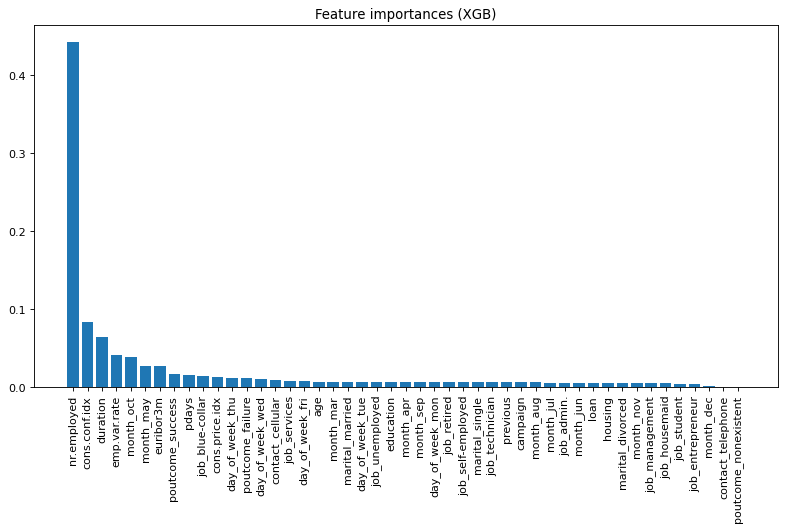

In [60]:
#get feature importances from the model
from matplotlib.pyplot import figure
figure(figsize=(12, 6), dpi=80)

headers = ["name", "score"]
values = sorted(zip(X_train.columns, xgb.feature_importances_), key=lambda x: x[1] * -1)
xgb_feature_importances = pd.DataFrame(values, columns = headers)

#plot feature importances
x_pos = np.arange(0, len(xgb_feature_importances))
plt.bar(x_pos, xgb_feature_importances['score'])
plt.xticks(x_pos, xgb_feature_importances['name'])
plt.xticks(rotation=90)
plt.title('Feature importances (XGB)')

plt.show()

Here we can see that earlier, duration was the important feature based on random forest and gini index, but as we see from the xgboost alogorith, employed is the important feature. Based on the employment we can say whether user will subscribe the service or not.

As we can see from the diagram showing feature importances, the most important features are:
Customer's employement,
cons.fonfidx,
duration

In [61]:
df.loc[df['y'] == 'yes', 'y'] = 1
df.loc[df['y'] == 'no', 'y'] = 0

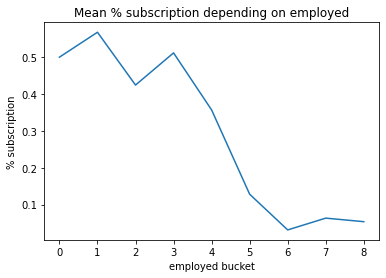

In [62]:
df_new = df.copy()
#introduce new column 'balance_buckets' to  ''
df_new['employed_buckets'] = pd.qcut(df['nr.employed'], 50, labels=False, duplicates = 'drop')
df.replace({False: 0, True: 1}, inplace=True)

#group by 'balance_buckets' and find average campaign outcome per balance bucket
mean_deposit = df_new.groupby(['employed_buckets'])['y'].mean()

#plot
plt.plot(mean_deposit.index, mean_deposit.values)
plt.title('Mean % subscription depending on employed')
plt.xlabel('employed bucket')
plt.ylabel('% subscription')
plt.show()

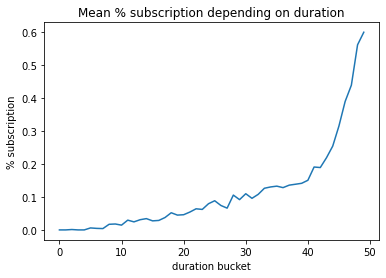

In [63]:
df_new = df.copy()
#introduce new column 'balance_buckets' to  ''
df_new['duration_buckets'] = pd.qcut(df['duration'], 50, labels=False, duplicates = 'drop')
df.replace({False: 0, True: 1}, inplace=True)

#group by 'balance_buckets' and find average campaign outcome per balance bucket
mean_deposit = df_new.groupby(['duration_buckets'])['y'].mean()

#plot
plt.plot(mean_deposit.index, mean_deposit.values)
plt.title('Mean % subscription depending on duration')
plt.xlabel('duration bucket')
plt.ylabel('% subscription')
plt.show()

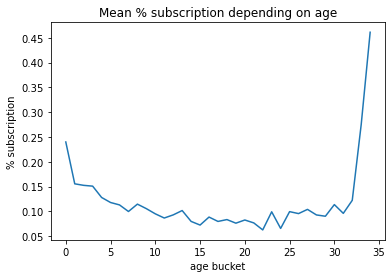

In [64]:
df_new = df.copy()
#introduce new column 'balance_buckets' to  ''
df_new['age_buckets'] = pd.qcut(df['age'], 50, labels=False, duplicates = 'drop')
df.replace({False: 0, True: 1}, inplace=True)

mean_deposit = df_new.groupby(['age_buckets'])['y'].mean()

#plot
plt.plot(mean_deposit.index, mean_deposit.values)
plt.title('Mean % subscription depending on age')
plt.xlabel('age bucket')
plt.ylabel('% subscription')
plt.show()

Conclusion: 
As per the graph, we can see that based on age the outcome of subscription is very low in the middle order range. it is high in the young age group and older people.
Duration is also played a key role in the outcome. With the duration of the talk, chances are high for a subscription. a graph is showing a continuous increasing pattern.